## Model Comparison Exercise

The purpose of this notebook is to expand on the simple linear regression model from the previous notebook (03)
by comparing it to several other simple versions of other models. This should suggest where next to focus modelling efforts.

**-- Results --**

With minimal setup for each of the four models, XGBoost shows the most promise.

**Linear Regression:**

MSE -- 1.036290 -- R-squared -- 0.933769 -- CV Score -- 5.008637

**Random Forest:**

MSE -- 0.935484 -- R-squared -- 0.940211 -- CV Score -- 1.150044

**SVR:**

MSE -- 0.993952 -- R-squared -- 0.936474 -- CV Score -- 2.843393

**XGBoost:**

MSE -- 0.877016 -- R-squared -- 0.943948 -- CV Score -- 1.218393

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=RuntimeWarning)

## Import Data

In [2]:
# Load the preprocessed data
df = pd.read_csv('~/Projects/surfline/data/preprocessed.dat', index_col=0, parse_dates=True)
print(f"Data shape: {df.shape}")
# df.head()

Data shape: (2480, 30)


In [3]:
df.columns

Index(['WVHT_max', 'DPD_at_peak', 'DPD_mean', 'APD_mean', 'MWD_at_peak',
       'MWD_mean', 'wave_power', 'WVHT_max_2d_avg', 'MWD_2d_avg', 'APD_2d_avg',
       'DPD_mean_2d_avg', 'wave_power_2d_avg', 'WVHT_max_3d_avg', 'MWD_3d_avg',
       'APD_3d_avg', 'DPD_mean_3d_avg', 'wave_power_3d_avg',
       'WVHT_max_MWD_interact', 'WVHT_max_DPD_mean_interact',
       'WVHT_max_2d_avg_log', 'APD_2d_avg_log', 'wave_power_2d_avg_log',
       'WVHT_max_3d_avg_log', 'MWD_wave_power_interact_log', 'nshor',
       'DPD_mean_wave_power_interact^2', 'WVHT_max_APD_interact^2',
       'WVHT_max_APD_interact_log^2', 'day_cos', 'is_winter'],
      dtype='object')

## Preprocessing

In [4]:
# List the columns to use as features -- all 29 available features
feature_columns = ['WVHT_max', 'DPD_at_peak', 'DPD_mean', 'APD_mean', 'MWD_at_peak',
       'MWD_mean', 'wave_power', 'WVHT_max_2d_avg', 'MWD_2d_avg', 'APD_2d_avg',
       'DPD_mean_2d_avg', 'wave_power_2d_avg', 'WVHT_max_3d_avg', 'MWD_3d_avg',
       'APD_3d_avg', 'DPD_mean_3d_avg', 'wave_power_3d_avg',
       'WVHT_max_MWD_interact', 'WVHT_max_DPD_mean_interact',
       'WVHT_max_2d_avg_log', 'APD_2d_avg_log', 'wave_power_2d_avg_log',
       'WVHT_max_3d_avg_log', 'MWD_wave_power_interact_log',
       'DPD_mean_wave_power_interact^2', 'WVHT_max_APD_interact^2',
       'WVHT_max_APD_interact_log^2', 'day_cos', 'is_winter']

# Specify target variable
target_column = 'nshor'

# Create X (features) and y (target)
X = df[feature_columns]
y = df[target_column]

In [5]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # using the same scale fitted on the training data to avoid data leakage

## Train Multiple Models

In [7]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'XGBoost': XGBRegressor(learning_rate=0.05, n_estimators=100, random_state=42)
}

In [8]:
# Train models
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_rounded = np.round(y_pred)
    
    mse = mean_squared_error(y_test, y_pred_rounded)
    r2 = r2_score(y_test, y_pred_rounded)
    cv_score = np.mean(cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='neg_mean_squared_error'))
    
    results.append({
        'Model': name,
        'MSE': mse,
        'R-squared': r2,
        'CV Score': -cv_score
    })

## Evaluate Models

In [9]:
# Display results
results_df = pd.DataFrame(results)
print(results_df)

               Model       MSE  R-squared  CV Score
0  Linear Regression  1.036290   0.933769  5.008637
1      Random Forest  0.935484   0.940211  1.150044
2                SVR  0.993952   0.936474  2.843393
3            XGBoost  0.877016   0.943948  1.218393


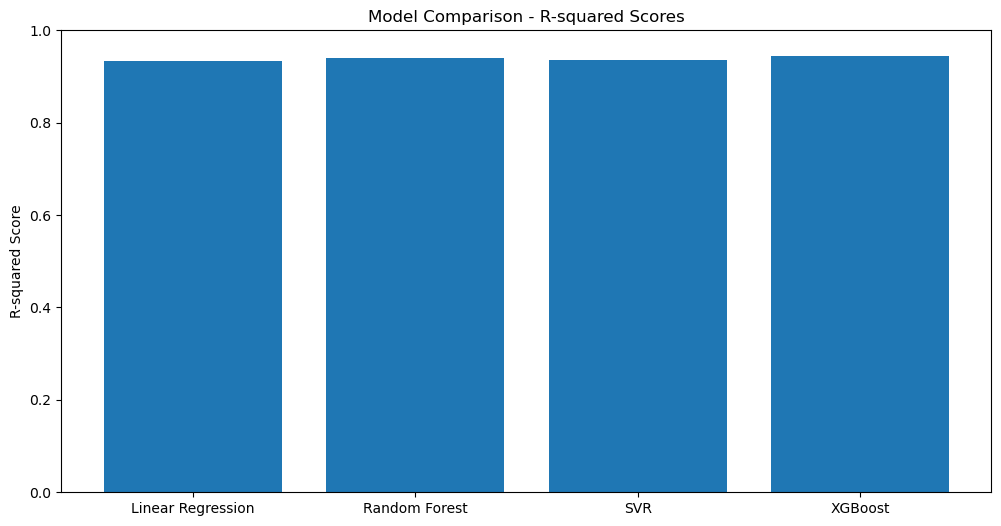

In [10]:
# Plot model comparison
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['R-squared'])
plt.title('Model Comparison - R-squared Scores')
plt.ylabel('R-squared Score')
plt.ylim(0, 1)
plt.show()

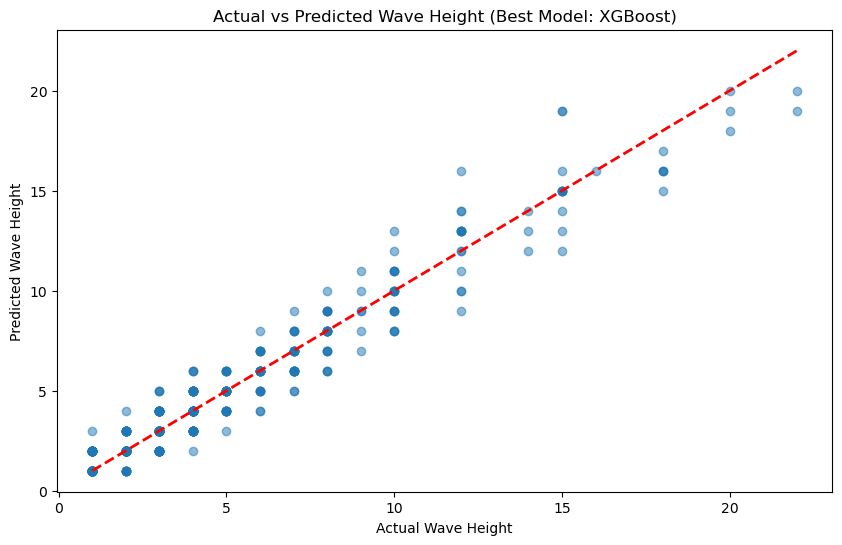

In [11]:
# Plot actual vs predicted for best model
best_model = models[results_df.loc[results_df['R-squared'].idxmax(), 'Model']]
y_pred_best = np.round(best_model.predict(X_test_scaled))

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Wave Height")
plt.ylabel("Predicted Wave Height")
plt.title(f"Actual vs Predicted Wave Height (Best Model: {results_df.loc[results_df['R-squared'].idxmax(), 'Model']})")
plt.show()